```
Note:  AWS Vine data from an S3 bucket does not seem to be available anymore.    

```

# Goal

The goal of this notebook is to explore Amazon reviews and see if Vine users versus non-Vine users show different tendencies when reviewing products.  

## Environment Setup and Dependencies

In [ ]:
# Dependencies
import os

# set spark version
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [2,077 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Relea

In [ ]:
# setup pyspark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AmazonAnalysis")\
  .config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar")\
  .getOrCreate()

# Extract 
*  Create connectiont to S3 bucket and file

| DATA COLUMNS | Description  |
| --- | ---|
|marketplace |   - 2 letter country code of the marketplace where the review was written. |
| customer_id |      - Random identifier that can be used to aggregate reviews written by a single author.  |
|review_id  |       - The unique ID of the review.  |
|product_id |       - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.  |
|product_parent |   - Random identifier that can be used to aggregate reviews for the same product.  |
|product_title |    - Title of the product.  |
|product_category | - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). | 
|star_rating   |    - The 1-5 star rating of the review.  |
|helpful_votes |    - Number of helpful votes.|  
|total_votes  |     - Number of total votes the review received. | 
|vine     |         - Review was written as part of the Vine program.  |
|verified_purchase |- The review is on a verified purchase. | 
|review_headline  | - The title of the review.| 
|review_body  |     - The review text.  |
|review_date  |     - The date the review was written.  |

DATA FORMAT  
>Tab ('\t') separated text file, without quote or escape characters.  
First line in each file is header; 1 line corresponds to 1 record.  

In [ ]:
# add files to pyspark
from pyspark import SparkFiles

# Load file
# https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt
url2 = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_PC_v1_00.tsv.gz" 
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Health_Personal_Care_v1_00.tsv.gz"
filename = "amazon_reviews_us_Health_Personal_Care_v1_00.tsv.gz"
spark.sparkContext.addFile(url)

# read file
df = spark.read.csv(SparkFiles.get(filename), header=True, inferSchema=True, sep='\t', timestampFormat="mm/dd/yy")
df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|     650634| R3EQSTM9PWRAL|B0091LBZSU|     578484426|Demograss Capsule...|Health & Personal...|          3|            0|          0|   N|                Y|         Three Stars|Only came with 30...| 2015-08-31|
|         US|   19827510| RBWPRK17XKIXD|B00PWW3LQ6|     456433146|Viva Labs #1 Prem...|Health & Personal

In [ ]:
# check data distribution
df.groupby('vine').count().show()

+----+-------+
|vine|  count|
+----+-------+
|null|    234|
|   Y|  32026|
|   N|5299189|
+----+-------+



# Transform
*  Remove bad and duplicated records
*  Check number of records left
*  Convert column datatypes if needed

In [ ]:
# size of dataframe (rows)
print(df.count())

# drop incomplete records
df = df.dropna()
print(df.count())

# drop duplicated records (if any; should be none)
df = df.dropDuplicates()
print(df.count())

# check datatypes
df.printSchema()

5331449
5330701
5330701
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [ ]:
# convert review-date to date format
from pyspark.sql.functions import to_date, col
complete_table = df.withColumn("review_date", to_date(col("review_date"),"yyyy-MM-dd").alias("review_date"))

# check change
complete_table.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



# General Review
- What questions do I formulate from looking at the data?

In [ ]:
# all data
complete_table.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   52769212|R1007YJJIFAC9J|B009UHTGT0|     245155553|  Scrub Daddy 8 Pack|Health & Personal...|          5|            0|          0|   N|                Y|Just As Good As t...|Reviewed this bef...| 2013-08-27|
|         US|   22075855|R100F8VKMH0GML|B006Z96OI2|     556998710|Marquee 5-Piece A...|Health & Personal

In [ ]:
# earliest date
complete_table.agg({'review_date': 'max'}).show()

+----------------+
|max(review_date)|
+----------------+
|      2015-08-31|
+----------------+



In [ ]:
# latest date
complete_table.agg({'review_date': 'min'}).show()

+----------------+
|min(review_date)|
+----------------+
|      1999-02-06|
+----------------+



In [ ]:
# compare vine verus non-vine
from pyspark.sql.functions import col, asc,desc, mean, stddev, count, max
complete_table.groupby('vine').agg(count('vine'), mean('star_rating'), stddev('star_rating')).show()

+----+-------------------+-----------+
|vine|stddev(star_rating)|count(vine)|
+----+-------------------+-----------+
|   Y| 1.0367159293576627|      32025|
|   N| 1.3256706613283846|    5298676|
+----+-------------------+-----------+



Review Comments:
*  Most columns are pretty self-explanitory
*  Intiail thought is that I need to specifically target the `customer_id`, `product_title`, and `vine` status to determine bias relationships
*  Need to check to see what these columns mean or affect the data:
  *  `product_parent`
  *  `vine`
  *  `verified_purchase`
*  Should probably go to Amazon and check out one of the titles and the reviews section since that is where this info should come from.

# Customer Inspection

In [ ]:
# check customer/review data
from pyspark.sql.functions import col, asc,desc, mean, stddev, count
top_customers = complete_table.groupby('customer_id').agg(count('customer_id'), mean('star_rating'), stddev('star_rating')).sort(col('count(customer_id)').desc())
top_customers.show()

+-----------+------------------+------------------+------------------------+
|customer_id|count(customer_id)|  avg(star_rating)|stddev_samp(star_rating)|
+-----------+------------------+------------------+------------------------+
|   12201275|               446| 4.961883408071749|     0.21385712933880205|
|   50820654|               432| 4.574074074074074|      0.6383520503671601|
|   50199793|               358| 4.879888268156424|      0.3954757994229296|
|   39789300|               348| 4.669540229885057|      0.7182213189053961|
|   14034704|               298|4.5134228187919465|      1.0289517871204121|
|   22073263|               286| 4.510489510489511|      0.8933841268654811|
|   51812418|               275| 4.610909090909091|       0.654482781044297|
|   51346302|               274| 4.310218978102189|      1.0353307886771428|
|   43856165|               237|  4.40084388185654|       0.804962972155117|
|   52215985|               221| 4.266968325791855|      1.1103825482857876|

Above shows that the reviewers with a significant number of reviews score movies very differently.  It's not clear how the reviewers would score the same set of movies but taking a sample of over 300 movies the average rating ranged between 2.58 to 4.64.  Analyzing for survey response bias will be a separate notebook since that is a more involved process and there is a chance that with the number of reviews here that some interesting information can be extracted.  

# Product Parent Inspection

In [ ]:
# not sure what product_parent means; check several values
review_list = complete_table.filter('product_parent == 949699275')
review_list.show()

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   25702237|R3QJ3GF8GHE4XK|B001KXZ808|     949699275|EatSmart Precisio...|Health & Personal...|          4|            0|          2|   N|                Y|           It's Nice|I like the scale,...| 2015-08-23|
|         US|   13117379| RS9KS3T020FW7|B001KXZ808|     949699275|EatSmart Precisio...|Health & Personal

In [ ]:
# check popular product
review_product_parent_record = complete_table.filter('product_parent == 635288976')
review_product_parent_record.show()

+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|    product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+--------------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   33748626|R19MJ6GWUW5287|B00N2BVTJU|     635288976|Fitbit Charge Wir...|Health & Personal...|          5|            0|          0|   N|                Y|          Five Stars|I bought this as ...| 2015-08-24|
|         US|   37573616|R3RHU9QIN0ZQZU|B00N2BVOUE|     635288976|Fitbit Charge Wir...|Health & Personal

In [ ]:
# check varieity of product titles within one product parent
review_product_parent_record.groupby('product_title').agg({'product_title':'count'}).show()

+--------------------+--------------------+
|       product_title|count(product_title)|
+--------------------+--------------------+
|Fitbit - Charge W...|                   2|
|Fitbit Charge Wir...|                5995|
+--------------------+--------------------+



Product Parent Comments:
*  shows that product parent is a grouping of related movie titles
*  product parent is probably a better filter metric for standard movies but not series.  
*  Do sequels to movies fall into the same product parent code?

In [ ]:
# look at to product parent
top_product_parent_expanded = complete_table.groupby('product_parent').agg(count('product_parent'), mean('star_rating'), stddev('star_rating'), max('product_title')).sort(col("count(product_parent)").desc())
top_product_parent_expanded.show()

+--------------+---------------------+------------------+------------------------+--------------------+
|product_parent|count(product_parent)|  avg(star_rating)|stddev_samp(star_rating)|  max(product_title)|
+--------------+---------------------+------------------+------------------------+--------------------+
|     949699275|                18988| 4.596745312829155|      0.9755875931244017|Eatsmart Esbs-01 ...|
|     305113156|                15478|3.6863935909032173|      1.5258483286578186|Fitbit Flex Wirel...|
|     308537931|                11596| 4.703518454639531|      0.8259846631899321|Eatsmart Precisio...|
|     152365337|                 9908| 4.374646750100928|      1.1586265970372869|Fitbit One Wirele...|
|     284004219|                 9704| 4.066055234954658|      1.4461603786262602|Ubervita W700 The...|
|     731502134|                 9143| 4.061139669692661|      1.3713647645707587|NatureWise Pure G...|
|     366100425|                 8102| 4.091212046408295|       

In [ ]:
# Look at top product titles
# slightly different than above
top_reviewed_titles = complete_table.groupby('product_parent', 'product_title').agg(count('product_title'), mean('star_rating'), stddev('star_rating')).sort(col('count(product_title)').desc())
top_reviewed_titles.show()

+--------------+--------------------+--------------------+-------------------+------------------+------------------------+
|product_parent|       product_title|count(product_title)|max(product_parent)|  avg(star_rating)|stddev_samp(star_rating)|
+--------------+--------------------+--------------------+-------------------+------------------+------------------------+
|     949699275|EatSmart Precisio...|               18986|          949699275| 4.596702833666913|      0.9756301988070101|
|     305113156|Fitbit Flex Wirel...|               15478|          305113156|3.6863935909032173|      1.5258483286578186|
|     308537931|Eatsmart Precisio...|               11593|          308537931| 4.703786767877167|      0.8253658327316256|
|     152365337|Fitbit One Wirele...|                9906|          152365337| 4.374621441550575|      1.1587204134334577|
|     284004219|Ubervita W700 The...|                9704|          284004219| 4.066055234954658|      1.4461603786262602|
|     731502134|

# Vine Reviewer Inspection

## Simple Review
*  Compare means and standard deviations

In [ ]:
# collect information about reviewers (vine versus not vine)
complete_table.groupby('vine').agg(count('vine'), mean('star_rating'), stddev('star_rating')).show()

+----+-----------+-----------------+------------------------+
|vine|count(vine)| avg(star_rating)|stddev_samp(star_rating)|
+----+-----------+-----------------+------------------------+
|   Y|      32025| 4.03800156128025|      1.0367159293576627|
|   N|    5298676|4.162567969809817|      1.3256706613283846|
+----+-----------+-----------------+------------------------+



In [ ]:
# compare describe() to above calculation
not_vine_members = complete_table.filter('vine == "N"')
not_vine_members.describe('star_rating').show()


+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|           5298676|
|   mean| 4.162567969809817|
| stddev|1.3256706613283846|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [ ]:
# filter dataframe
vine_members = complete_table.filter('vine == "Y"')

In [ ]:
# average rating
star_mean = vine_members.agg(mean('star_rating')).collect()[0]['avg(star_rating)']
star_mean

4.03800156128025

In [ ]:
# create star rating residual column
vine_members = vine_members.withColumn("residual_stars", col('star_rating') - star_mean)
vine_members.select(['product_title', 'star_rating', 'residual_stars']).show()

+--------------------+-----------+--------------------+
|       product_title|star_rating|      residual_stars|
+--------------------+-----------+--------------------+
|TriCalm Clinical ...|          4|-0.03800156128025023|
|MILK Stinky Winky...|          4|-0.03800156128025023|
|Finish Powerball ...|          5|  0.9619984387197498|
|Swiffer WetJet Ha...|          4|-0.03800156128025023|
|MILK Stinky Winky...|          4|-0.03800156128025023|
|PediaSure Sidekic...|          4|-0.03800156128025023|
|Nature's Truth Ar...|          5|  0.9619984387197498|
|Ubervita Uberslee...|          4|-0.03800156128025023|
|SmartyPants Vitam...|          5|  0.9619984387197498|
|SmartyPants Vitam...|          5|  0.9619984387197498|
|Hefty Ultra Flex ...|          4|-0.03800156128025023|
|Febreze Air Fresh...|          5|  0.9619984387197498|
|Viva Labs #1 Prem...|          4|-0.03800156128025023|
|RAYOVAC AA FUSION...|          5|  0.9619984387197498|
|Downy Fresh Prote...|          4|-0.03800156128

In [ ]:
# plot and measure skewness
import seaborn as sns
from scipy.stats import skew
data = list(vine_members.select('residual_stars').toPandas()['residual_stars'])
print(skew(data))
sns.histplot(data)

### Experiment with Normalizing Data
*  Most standard functions won't work in theory

-2.0606256387090296


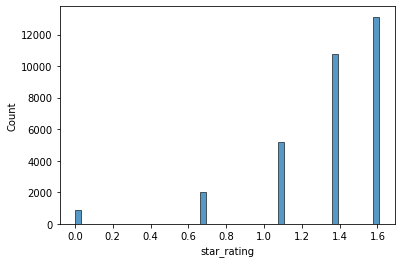

In [ ]:
# log transform
import numpy as np

data_log = np.log(vine_members.select('star_rating').toPandas()['star_rating'])
print(skew(data_log))
sns.histplot(data_log)

-1.4627892953695367


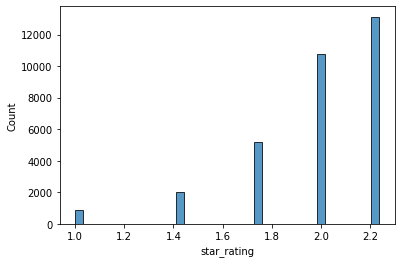

In [ ]:
# square root transform
data_sqrt = np.sqrt(vine_members.select('star_rating').toPandas()['star_rating'])
print(skew(data_sqrt))
sns.histplot(data_sqrt)

-0.35433759942468496


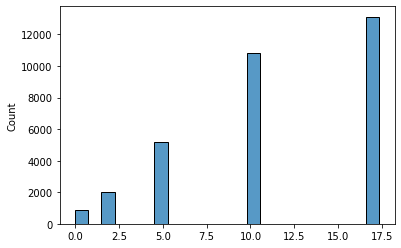

In [ ]:
# boxcox transform
from scipy import stats
import pandas as pd
data_boxcox = stats.boxcox(vine_members.select('star_rating').toPandas()['star_rating'])[0]
print(pd.Series(data_boxcox).skew())
sns.histplot(data_boxcox)

### Wilcoxon Rank Test for equivalency (not normal distributed data)

In [ ]:
# create two equal size lists
# should probably collect more random data for ydata
from scipy.stats import wilcoxon

xdata = list(vine_members.select('star_rating').toPandas()['star_rating'])
size = len(xdata)
ydata = list(not_vine_members.select('star_rating').toPandas()['star_rating'])[0:size]
wilcoxon(x=xdata, y=ydata)

With a low p-value, we fail to reject that the two samples are the same (null hypothesis).

### Try custom function to normalize the data
*  Trend - data is linear with positive slope
*  Theory - move data to the left so mean is at zero (x-4.03); move data up so all data is positive on the y (0.15).  Square the X adjustment (x-4.03)**2 so values to the negative X become positive and forms a 'U' shape.
*  Trial & Error - adjust the vertical component (0.15) until skewness is small.

-0.03750055150560899


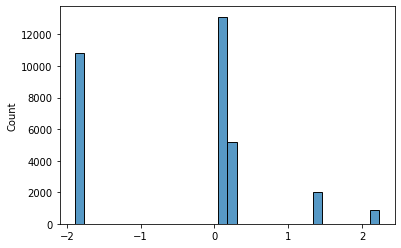

In [ ]:
def reciprical(x):
  return np.log((x-4.03)**2 + 0.15)

data_func = np.array([reciprical(i) for i in vine_members.select('star_rating').toPandas()['star_rating']])
print(skew(data_func))
sns.histplot(data_func)

### T-test



In [ ]:
from scipy.stats import ttest_ind

adata_func = np.array([reciprical(i) for i in vine_members.select('star_rating').toPandas()['star_rating']])
bdata_func = np.array([reciprical(i) for i in not_vine_members.select('star_rating').toPandas()['star_rating']])

ttest_ind(adata_func, bdata_func)

Ttest_indResult(statistic=-85.00629672222198, pvalue=0.0)

So this data is not exactly an automatic determination of what hypothesis test to use.  The data is not normal and is actually fairly linear.  The data is also not continuous and is likert data (star rating).  The initial view of means and standard deviation were very similar.  I used the Wilcoxon Rank test on the original, unaltered data.  I also was able to normalize the data a bit and performed the t-test.  I have less faith in the t-test validity just due to the data.  Both tests indicate the two populations are equivalent. 

Overall I would use the Wilcoxon (Mann-Whitney) since it seems to correspond to the type of data much better.

Ref:  https://blog.minitab.com/en/adventures-in-statistics-2/best-way-to-analyze-likert-item-data-two-sample-t-test-versus-mann-whitney 

# Additional information based on verified purchases

In [ ]:
# only looking at Verified purchases by non-vine members
verified_purchase = complete_table.filter('verified_purchase == "Y"')
not_vine_members = verified_purchase.filter('vine == "N"')
not_vine_members.describe('star_rating').show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|           4447806|
|   mean| 4.173831322679091|
| stddev|1.3074905723562253|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [ ]:
# only looking at Verified purchases by vine members
# note:  This looks like a potential significant grouping but the number of records is 
# low in comparison of the dataset as a whole so these are really more like outliers.
# analyzing the specific behavior of the people making these 275 reviews could be interesting.  
vine_members = verified_purchase.filter('vine == "Y"')
vine_members.describe('star_rating').show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|               275|
|   mean| 4.538181818181818|
| stddev|0.7258247031261855|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [ ]:
# only looking at unverified purchases by non-vine members
not_verified_purchase = complete_table.filter('verified_purchase == "N"')
not_vine_members = not_verified_purchase.filter('vine == "N"')
not_vine_members.describe('star_rating').show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|            850870|
|   mean| 4.103690340475043|
| stddev|1.4154557187123111|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [ ]:
# only looking at unverified purchases by vine members
vine_members = not_verified_purchase.filter('vine == "Y"')
vine_members.describe('star_rating').show()

+-------+------------------+
|summary|       star_rating|
+-------+------------------+
|  count|             31750|
|   mean| 4.033669291338582|
| stddev|1.0379580936811539|
|    min|                 1|
|    max|                 5|
+-------+------------------+



### Summary

Some small sample size of vine verified purchases make it difficult to have meaningful analysis whether buyers have a bias based on what they buy compared to what they review and don't buy.  

Overall for this dataset, the vine reviewers look to be very similar to the non-vine reviewers.  There are pretty low cost items so it would be interesting to see what the results would be for a product that costs more and if behaviors change.   